# 🧠 Classificação de Imagens com CNN - CIFAR-10

## 📂 Contexto dos Dados

A base **CIFAR-10** é composta por 60.000 imagens coloridas divididas em 10 classes distintas:

- Avião  
- Automóvel  
- Pássaro  
- Gato  
- Veado  
- Cachorro  
- Sapo  
- Cavalo  
- Navio  
- Caminhão  

Cada imagem possui resolução de **32x32 pixels** com 3 canais RGB. O conjunto está separado em:
- **50.000 imagens** para treino  
- **10.000 imagens** para teste

É uma base clássica e amplamente utilizada em tarefas de visão computacional, ideal para avaliação de modelos de classificação de imagens.

---

## 🛠️ Técnicas Utilizadas

O modelo desenvolvido foi uma **Rede Neural Convolucional (CNN)** com a seguinte configuração:

- **3 blocos convolucionais**, cada um com:
  - Camadas `Conv2D` com ReLU
  - `BatchNormalization`
  - `MaxPooling2D`
  - `Dropout` para regularização
- Camada `Flatten` seguida de `Dense` com ReLU e `Dropout`
- Camada de saída com 10 neurônios (softmax)

Além disso, foram testados dois cenários:

1. **Treinamento tradicional** (sem data augmentation)
2. **Treinamento com Data Augmentation**, utilizando:
   - Rotações de até 15°
   - Deslocamentos horizontais e verticais
   - Espelhamento horizontal (flip)

---

## 📊 Métricas de Avaliação

Para a avaliação dos modelos, foram utilizadas as seguintes métricas:

- **Acurácia**: proporção de acertos no total de amostras
- **Precision**: proporção de predições positivas corretas
- **Recall**: proporção de positivos corretamente identificados
- **F1-score**: média harmônica entre precision e recall, útil em casos de classes desbalanceadas

Essas métricas oferecem uma visão abrangente do desempenho do modelo, indo além da simples acurácia e fornecendo um panorama sobre a qualidade da classificação.


## Imports

In [17]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Análise Exploratória (EDA)

### Carregar dataset

In [2]:
# Carregar o dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Lista de classes

In [4]:
# Lista de classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Mostrar 10 imagens aleatórias com labels

Visualmente vemos que o conjunto de dados tem resolução bem baixa, ou seja, pode até favorecer com que pessoas comuns errem na identificação dos objetos se não olharem atentamente.

/tmp/ipykernel_12030/663913738.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(y_train[idx])])


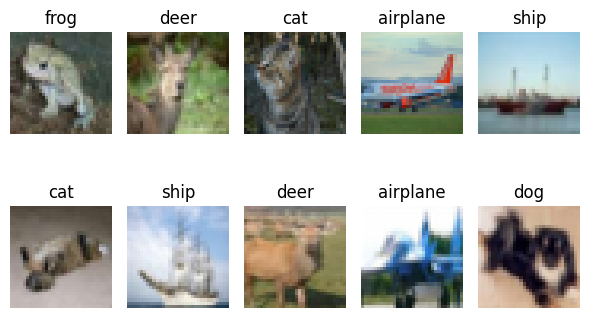

In [5]:
plt.figure(figsize=(6, 4))
for i in range(10):
    idx = np.random.randint(0, len(x_train))
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[idx])
    plt.title(classes[int(y_train[idx])])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Pré-Processamento

### Normalizar os dados (de 0-255 para 0-1)

Aqui normalizamos os dados no intervalo [0, 1]

In [6]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0 

### Converter os rótulos para one-hot encoding

In [7]:
y_train_cat = to_categorical(y_train, len(classes))
y_test_cat = to_categorical(y_test, len(classes))

### Verificar dimensões

In [8]:
x_train.shape

(50000, 32, 32, 3)

In [21]:
y_train_cat.shape

(50000, 10)

## Criando o modelo CNN

### Função importante

In [19]:
def metrics(model, x_test, y_test_cat):
    # Gera predições
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    # Calcula métricas
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='macro')
    recall = recall_score(y_true, y_pred_classes, average='macro')
    f1 = f1_score(y_true, y_pred_classes, average='macro')

    # Exibe resultados
    print(f'Acurácia : {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall   : {recall:.4f}')
    print(f'F1-score : {f1:.4f}')

def plots(history):
    # Plotar os gráficos 2x2
    history_dict = history.history
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Acurácia - Treinamento
    axs[0, 0].plot(history_dict['accuracy'], label='Treinamento')
    axs[0, 0].set_title('Acurácia - Treino')
    axs[0, 0].set_xlabel('Época')
    axs[0, 0].set_ylabel('Acurácia')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # Acurácia - Validação
    axs[0, 1].plot(history_dict['val_accuracy'], label='Validação', color='orange')
    axs[0, 1].set_title('Acurácia - Validação')
    axs[0, 1].set_xlabel('Época')
    axs[0, 1].set_ylabel('Acurácia')
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # Loss - Treinamento
    axs[1, 0].plot(history_dict['loss'], label='Treinamento', color='green')
    axs[1, 0].set_title('Loss - Treino')
    axs[1, 0].set_xlabel('Época')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    # Loss - Validação
    axs[1, 1].plot(history_dict['val_loss'], label='Validação', color='red')
    axs[1, 1].set_title('Loss - Validação')
    axs[1, 1].set_xlabel('Época')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].grid(True)
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

### Definindo arquitetura da CNN comum

Criamos um modelo de CNN comum com três camadas convolucionais, três camadas de subamostragem e uma camada densa. Utilizamos também regularizações com dropout para impedir que neurônios que estejam sobreamostrando com o conjunto de dados sejam congelados durante o treino.

In [10]:
def CNN_CIFAR10(x_train, y_train, x_test, y_test, epochs, sumarity=True):
    # Definir a arquitetura do modelo
    model = Sequential()

    # 1ª camada convolucional
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 2ª camada convolucional
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3ª camada convolucional
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Achatar e adicionar densa
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Regularização

    # Saída - 10 classes (CIFAR-10)
    model.add(Dense(10, activation='softmax'))

    # Compilar o modelo
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Resumo da arquitetura
    if sumarity:
        model.summary()
        return model

    # Treinamento do modelo
    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=64,
        validation_data=(x_test, y_test),
        callbacks=[early_stop]
    )

    #Plotando gráficos
    plots(history)

    return model

CNN_CIFAR10(0, 0, 0, 0, 0)

/home/jonnathann/Documentos/portifolio_jonnathann/env_ra/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-12 15:39:40.563752: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 160,202 (625.79 KB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=sequential, built=True>

### Definindo arquitetura da CNN com data argumentation

Aqui pegamos a mesma arquitetura que criamos a aplicamos técnica de data argumentation para impedir que a rede subreajuste totalmente com o conjunto de dados. Também usamos critério de parada: se em três época o valor de loss não diminuir, o treinamento é interrompido e como resultado fica o modelo com a última atualização de loss. Optamos por usar o data argumentation para analisarmos se há algum ganho de generalização em relação ao mesmo modelo sem data argumentation para esse conjunto de dados.

In [11]:
def CNN_CIFAR10_ARG(x_train, y_train, x_test, y_test, epochs, summary=True, use_augmentation=False):

    model = Sequential()

    # 1º bloco conv
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 2º bloco conv
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 3º bloco conv
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Flatten + Dense
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # Compilação
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    if summary:
        model.summary()
        return model

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    if use_augmentation:
        print("Usando Data Augmentation...")
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        )
        datagen.fit(x_train)

        history = model.fit(
            datagen.flow(x_train, y_train, batch_size=64),
            epochs=epochs,
            validation_data=(x_test, y_test),
            callbacks=[early_stop]
        )
    else:
        history = model.fit(
            x_train, y_train,
            batch_size=64,
            epochs=epochs,
            validation_data=(x_test, y_test),
            callbacks=[early_stop]
        )

    #Plotando gráficos
    plots(history)
        
    return model

CNN_CIFAR10_ARG(0, 0, 0, 0, 0, summary=True, use_augmentation=False)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

<Sequential name=sequential_1, built=True>

### Treinando o modelo CNN comum

Epoch 1/20


2025-04-11 10:01:36.902831: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.2735 - loss: 1.9126 - val_accuracy: 0.5144 - val_loss: 1.3431
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.5160 - loss: 1.3659 - val_accuracy: 0.5783 - val_loss: 1.1899
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.5755 - loss: 1.2020 - val_accuracy: 0.6301 - val_loss: 1.0468
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 76ms/step - accuracy: 0.6233 - loss: 1.0719 - val_accuracy: 0.6540 - val_loss: 0.9826
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.6564 - loss: 0.9817 - val_accuracy: 0.6655 - val_loss: 0.9299
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 76ms/step - accuracy: 0.6812 - loss: 0.9126 - val_accuracy: 0.6636 - val_loss: 0.9520
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 76ms/step - accuracy: 0.6958 - loss: 0.8701 - val_accuracy: 0.6905 - val_loss: 0.8677
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 76ms/step - accuracy: 0.7137 - loss: 0.8160 - val_accurac

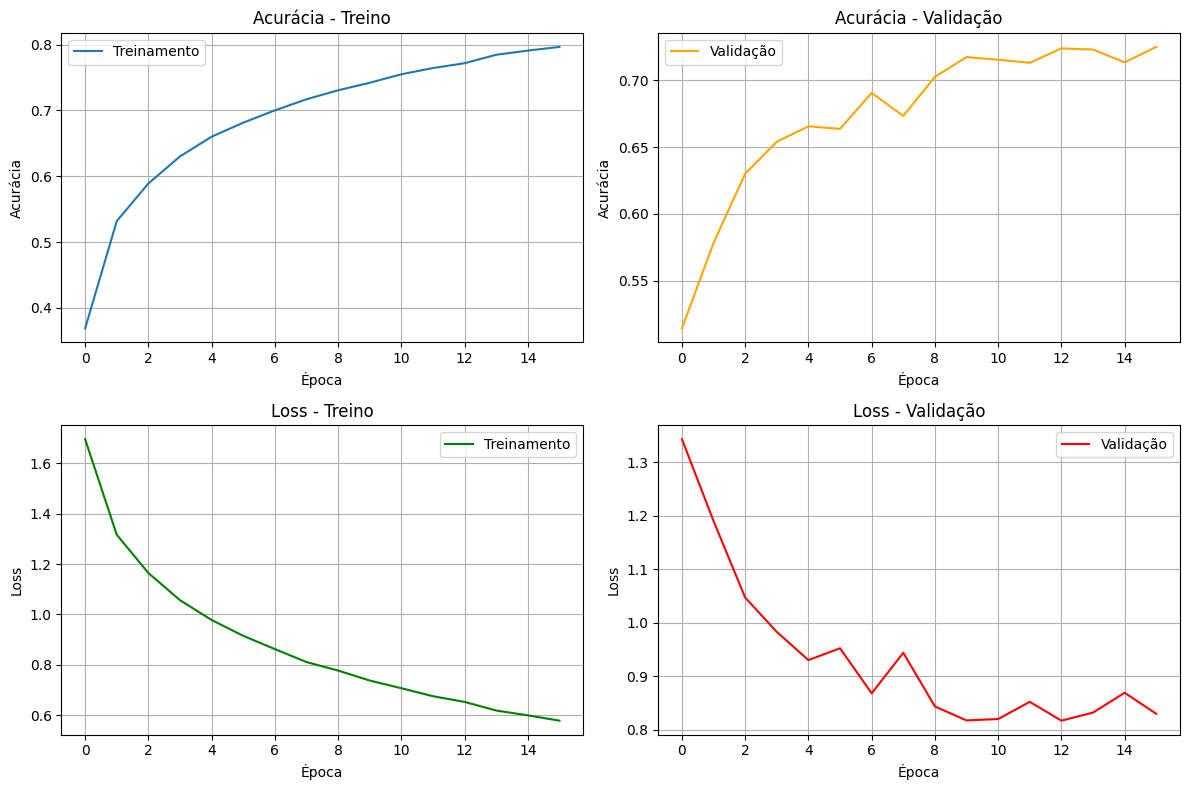

In [ ]:
model = CNN_CIFAR10(x_train, y_train_cat, x_test, y_test_cat, 20, sumarity=False)

#Salvando modelo salvo no diretório models
model.save("../models/cnn_cifar10_model.h5")

In [22]:
#Carregando modelo salvo no diretório models
_model = load_model("../models/cnn_cifar10_model.h5")

#Calculando métricas de desempenho
metrics(_model, x_test, y_test_cat)


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Acurácia : 0.7238
Precision: 0.7314
Recall   : 0.7238
F1-score : 0.7252


### Treinando CNN com data argumentation

Usando Data Augmentation...
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 520s 653ms/step - accuracy: 0.3342 - loss: 2.0675 - val_accuracy: 0.5107 - val_loss: 1.4566
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 519s 663ms/step - accuracy: 0.5454 - loss: 1.2706 - val_accuracy: 0.5909 - val_loss: 1.1660
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 533s 681ms/step - accuracy: 0.6216 - loss: 1.0640 - val_accuracy: 0.6640 - val_loss: 0.9723
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 535s 683ms/step - accuracy: 0.6682 - loss: 0.9543 - val_accuracy: 0.6658 - val_loss: 0.9999
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 534s 683ms/step - accuracy: 0.6988 - loss: 0.8650 - val_accuracy: 0.6849 - val_loss: 0.9264
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 535s 684ms/step - accuracy: 0.7141 - loss: 0.8229 - val_accuracy: 0.7470 - val_loss: 0.7294
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 539s 689ms/step - accuracy: 0.7313 - loss: 0.7810 - val_accuracy: 0.7566 - val_loss: 0.7160
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 539s 690

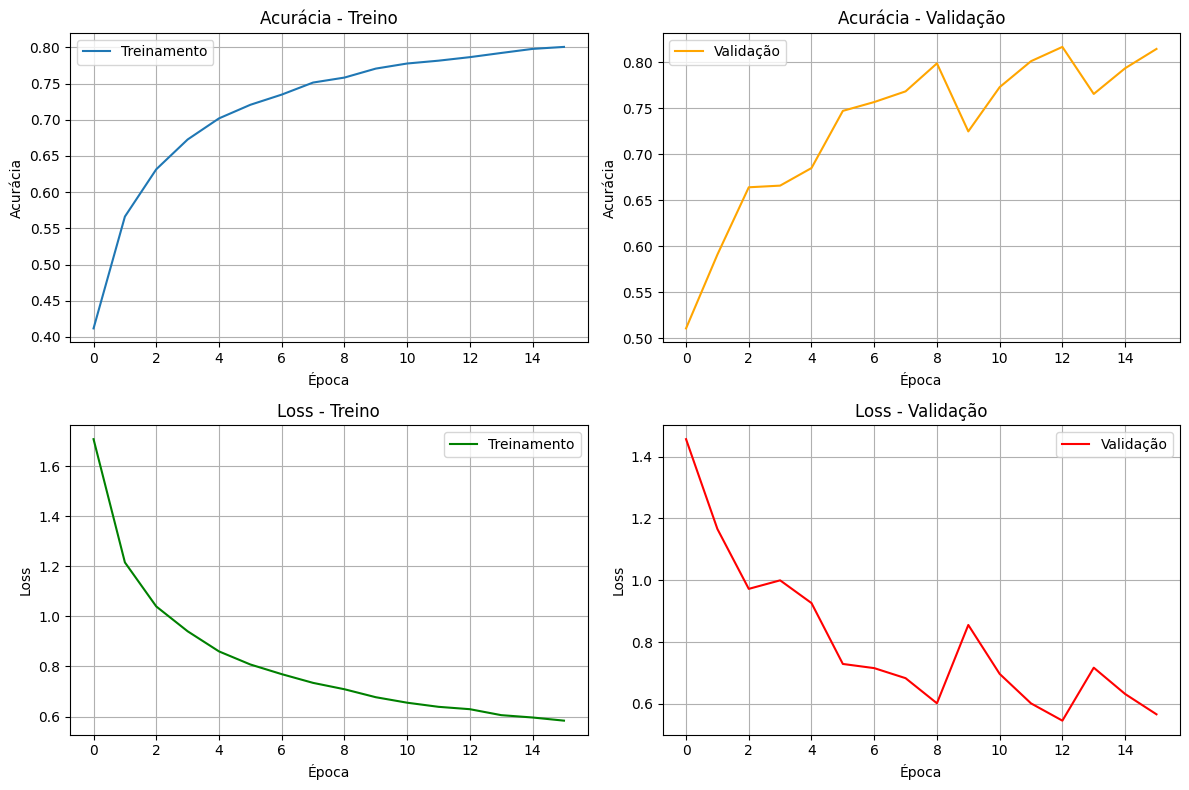

In [44]:
model =  CNN_CIFAR10_ARG(x_train, y_train_cat, x_test, y_test_cat, 20, summary=False, use_augmentation=True)

#Salvando modelo salvo no diretório models
model.save("../models/cnn_cifar10_dtarg_model.h5")

In [23]:
#Carregando modelo salvo no diretório models
_model_dtarg = load_model("../models/cnn_cifar10_dtarg_model.h5")

#Calculando métricas de desempenho
metrics(_model_dtarg, x_test, y_test_cat)

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step
Acurácia : 0.8165
Precision: 0.8197
Recall   : 0.8165
F1-score : 0.8121


## 🧪 Resultados: Classificação com CNN na base CIFAR-10

### 🔸 Modelo sem Data Augmentation
- **Acurácia**: 0.7238  
- **Precision**: 0.7314  
- **Recall**: 0.7238  
- **F1-score**: 0.7252

### 🔹 Modelo com Data Augmentation
- **Acurácia**: 0.8165  
- **Precision**: 0.8197  
- **Recall**: 0.8165  
- **F1-score**: 0.8121

---

## 🧠 Conclusão

A partir dos experimentos realizados com a base CIFAR-10 utilizando redes convolucionais, foi possível notar uma melhoria significativa no desempenho do modelo ao aplicar **data augmentation**.

Enquanto o modelo treinado sem essa técnica obteve resultados razoáveis, ele ainda apresentava certa limitação na generalização, refletida nos valores mais baixos de acurácia e F1-score.

Por outro lado, ao utilizar data augmentation — com rotações, deslocamentos e flips horizontais — o modelo demonstrou maior capacidade de generalização. Isso se reflete no aumento expressivo de todas as métricas, especialmente na **acurácia**, que saltou de **72,38% para 81,65%**.

Esses resultados comprovam que técnicas de aumento de dados são essenciais para melhorar a robustez de modelos de visão computacional, especialmente em bases com imagens variadas e desafiadoras como o CIFAR-10.
